In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import sys
sys.path.append('..')
from src.data_notebook import *
from src.utils import *
from src.models import *

### import pandas as pd
import einops
from pathlib import Path
import pytorch_lightning as pl
import kornia.filters as kfilts
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import xarray as xr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -66.3 
lon_max = -53.5
lat_min = 31.7
lat_max = 44.5

datadir="/dmidata/users/maxb/NATL_dataset"
datamodule = BaseDataModule(input_da=load_altimetry_data(datadir+"/natl_gf_w_5nadirs_swot.nc"),
                            domains={'train': {'time': slice('2013-02-24', '2013-09-30',)},
                                     'val': {'time': slice('2012-12-15', '2013-02-24',)},
                                     'test': {'time': slice('2012-10-01', '2012-12-20',)}},
                            xrds_kw={'patch_dims': {'time': 15, 'lat':  128, 'lon': 128},
                                     'strides': {'time': 1, 'lat': 128, 'lon': 128},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,))},
                            dl_kw={'batch_size': 1, 'num_workers': 1},
                            grad=False,
                            #aug_kw={'aug_factor': 1, 'aug_only': True},
                            resize_factor=2)
datamodule.setup()

Norm stats (0.3047108663749711, 0.3879814586804132)


torch.Size([1, 15, 128, 128])


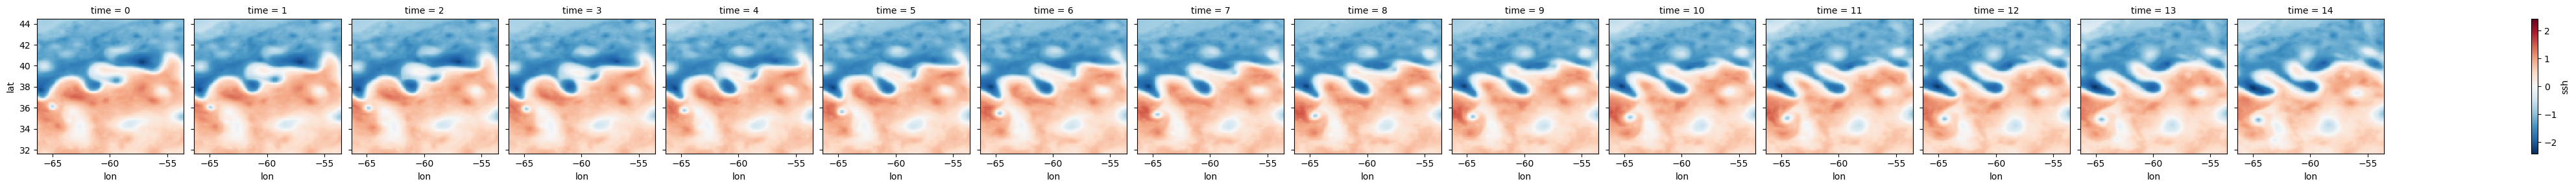

In [3]:
# datamodule.train_ds[0].input has shape (15, 240, 240)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),datamodule.train_ds[0].tgt)},
           coords={'time':np.arange(15),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',col_wrap=15)

data_loader = datamodule.train_dataloader()
k=10
my_sample = next(itertools.islice(data_loader, k, None))
print(my_sample[0].shape)

# Observational cost and Prior cost

In [4]:
class BaseObsCost(nn.Module):
    def __init__(self, w=1) -> None:
        super().__init__()
        self.w=w

    def forward(self, state, y):
        msk = y.isfinite()
        return self.w * F.mse_loss(state[msk], y.nan_to_num()[msk])

class BilinAEPriorCost(nn.Module):
    def __init__(self, dim_in, dim_hidden, kernel_size=3, downsamp=None, bilin_quad=True, nt=None):
        super().__init__()
        self.nt = nt
        self.bilin_quad = bilin_quad
        self.conv_in = nn.Conv2d(
            dim_in, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.conv_hidden = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.bilin_1 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_21 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_22 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.conv_out = nn.Conv2d(
            2 * dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )

    def forward_ae(self, x):
        x = self.down(x)
        x = self.conv_in(x)
        x = self.conv_hidden(F.relu(x))

        nonlin = self.bilin_21(x)**2 if self.bilin_quad else (self.bilin_21(x) * self.bilin_22(x))
        x = self.conv_out(
            torch.cat([self.bilin_1(x), nonlin], dim=1)
        )
        x = self.up(x)
        return x

    def forward(self, state, exclude_params=False):
        return F.mse_loss(state, self.forward_ae(state))

# Define the solver (Diff)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Tuple, Callable
from einops import rearrange
from einops.layers.torch import Rearrange

def GroupNorm(channels: int) -> nn.GroupNorm:
    return nn.GroupNorm(num_groups=min(32, channels // 4), num_channels=channels)


class NoiseLevelEmbedding(nn.Module):
    def __init__(self, channels: int, scale: float = 16.0) -> None:
        super().__init__()
        # W is a fixed vector of frequencies scaled by this scale factor
        self.W = nn.Parameter(torch.randn(channels // 2) * scale, requires_grad=False)

        self.projection = nn.Sequential(
            nn.Linear(channels, 4 * channels),
            nn.SiLU(),
            nn.Linear(4 * channels, channels),
            Rearrange("b c -> b c () ()"),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x has shape (batch_size,)
        h = x[:, None] * self.W[None, :] * 2 * torch.pi  # scale frequencies by 2*pi
        h = torch.cat([torch.sin(h), torch.cos(h)], dim=-1)  # positional encoding

        return self.projection(h)


class UNetBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        noise_level_channels: int,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.input_projection = nn.Sequential(
            GroupNorm(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same"),
            nn.Dropout2d(dropout),
        )
        self.noise_level_projection = nn.Sequential(
            nn.SiLU(),
            nn.Conv2d(noise_level_channels, out_channels, kernel_size=1),
        )
        self.output_projection = nn.Sequential(
            GroupNorm(2*out_channels),
            nn.SiLU(),
            nn.Conv2d(2*out_channels, out_channels, kernel_size=3, padding="same"),
            nn.Dropout2d(dropout),
        )
        self.residual_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor, noise_level: torch.Tensor) -> torch.Tensor:
        h = self.input_projection(x)
        noise_proj = self.noise_level_projection(noise_level)
        noise_proj = noise_proj.expand(-1, -1, h.shape[2], h.shape[3])  # broadcast spatially
        h = torch.cat([h, noise_proj], dim=1)  # concat along channel dim
        return self.output_projection(h) + self.residual_projection(x)

class SelfAttention(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        n_heads: int = 8,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()

        self.dropout = dropout
        self.qkv_projection = nn.Sequential(
            GroupNorm(in_channels),
            nn.Conv2d(in_channels, 3 * in_channels, kernel_size=1, bias=False),
            Rearrange("b (i h d) x y -> i b h (x y) d", i=3, h=n_heads),
        )
        self.output_projection = nn.Sequential(
            Rearrange("b h l d -> b l (h d)"),
            nn.Linear(in_channels, out_channels, bias=False),
            Rearrange("b l d -> b d l"),
            GroupNorm(out_channels),
            nn.Dropout1d(dropout),
        )
        self.residual_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        q, k, v = self.qkv_projection(x).unbind(dim=0)
        output = F.scaled_dot_product_attention(
            q, k, v, dropout_p=self.dropout if self.training else 0.0, is_causal=False
        )
        output = self.output_projection(output)
        output = rearrange(output, "b c (x y) -> b c x y", x=x.shape[-2], y=x.shape[-1])
        return output + self.residual_projection(x)


class UNetBlockWithSelfAttention(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        noise_level_channels: int,
        n_heads: int = 8,
        dropout: float = 0.3,
    ) -> None:
        super().__init__()
        self.unet_block = UNetBlock(
            in_channels, out_channels, noise_level_channels, dropout
        )
        self.self_attention = SelfAttention(
            out_channels, out_channels, n_heads, dropout
        )

    def forward(self, x: torch.Tensor, noise_level: torch.Tensor) -> torch.Tensor:
        return self.self_attention(self.unet_block(x, noise_level))


class Downsample(nn.Module):
    def __init__(self, channels: int) -> None:
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange("b c (h ph) (w pw) -> b (c ph pw) h w", ph=2, pw=2),
            nn.Conv2d(4 * channels, channels, kernel_size=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.projection(x)


class Upsample(nn.Module):
    def __init__(self, channels: int) -> None:
        super().__init__()
        self.projection = nn.Sequential(
            nn.Upsample(scale_factor=2.0, mode="nearest"),
            nn.Conv2d(channels, channels, kernel_size=3, padding="same"),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.projection(x)

@dataclass
class UNetConfig:
    channels: int = 15
    noise_level_channels: int = 256
    noise_level_scale: float =  16.0
    n_heads: int = 8
    top_blocks_channels: Tuple[int, ...] = (64, 64)
    top_blocks_n_blocks_per_resolution: Tuple[int, ...] = (2, 2)
    top_blocks_has_resampling: Tuple[bool, ...] = (True, True)
    top_blocks_dropout: Tuple[float, ...] = (0.0, 0.0)
    mid_blocks_channels: Tuple[int, ...] = (128, 256)
    mid_blocks_n_blocks_per_resolution: Tuple[int, ...] = (4, 4)
    mid_blocks_has_resampling: Tuple[bool, ...] = (True, False)
    mid_blocks_dropout: Tuple[float, ...] = (0.0, 0.0)


class UNet(nn.Module):
    def __init__(self, config: UNetConfig) -> None:
        super().__init__()
        self.config = config

        self.input_projection = nn.Conv2d(
            3*config.channels, config.top_blocks_channels[0], kernel_size=3, padding="same"
        )
        self.noise_level_embedding = NoiseLevelEmbedding(config.noise_level_channels, config.noise_level_scale)

        self.top_encoder_blocks = self._make_encoder_blocks(
            config.top_blocks_channels + config.mid_blocks_channels[:1],
            config.top_blocks_n_blocks_per_resolution,
            config.top_blocks_has_resampling,
            config.top_blocks_dropout,
            self._make_top_block,
        )
        self.mid_encoder_blocks = self._make_encoder_blocks(
            config.mid_blocks_channels + config.mid_blocks_channels[-1:],
            config.mid_blocks_n_blocks_per_resolution,
            config.mid_blocks_has_resampling,
            config.mid_blocks_dropout,
            self._make_mid_block,
        )
        self.mid_decoder_blocks = self._make_decoder_blocks(
            config.mid_blocks_channels + config.mid_blocks_channels[-1:],
            config.mid_blocks_n_blocks_per_resolution,
            config.mid_blocks_has_resampling,
            config.mid_blocks_dropout,
            self._make_mid_block,
        )
        self.top_decoder_blocks = self._make_decoder_blocks(
            config.top_blocks_channels + config.mid_blocks_channels[:1],
            config.top_blocks_n_blocks_per_resolution,
            config.top_blocks_has_resampling,
            config.top_blocks_dropout,
            self._make_top_block,
        )
        self.output_projection = nn.Conv2d(config.top_blocks_channels[0], config.channels, kernel_size=3, padding="same")

    def forward(self, x: torch.Tensor, y: torch.Tensor, sigma: torch.Tensor, sigma_prime: torch.Tensor) -> torch.Tensor:
        
        mask_obs = ~torch.isnan(y)
        y = torch.nan_to_num(y)  
        h = self.input_projection(torch.cat((x, y, mask_obs), 1))
        
        emb1 = self.noise_level_embedding(sigma)
        emb2 = self.noise_level_embedding(sigma_prime)
        noise_emb = torch.cat([emb1, emb2], dim=1)

        top_encoder_embeddings = []
        for block in self.top_encoder_blocks:
            if isinstance(block, (UNetBlock, UNetBlockWithSelfAttention)):
                h = block(h, noise_emb)
                top_encoder_embeddings.append(h)
            else:
                h = block(h)

        mid_encoder_embeddings = []
        for block in self.mid_encoder_blocks:
            if isinstance(block, (UNetBlock, UNetBlockWithSelfAttention)):
                h = block(h, noise_emb)
                mid_encoder_embeddings.append(h)
            else:
                h = block(h)

        for block in self.mid_decoder_blocks:
            if isinstance(block, (UNetBlock, UNetBlockWithSelfAttention)):
                h = torch.cat((h, mid_encoder_embeddings.pop()), dim=1)
                h = block(h, noise_emb)
            else:
                h = block(h)

        for block in self.top_decoder_blocks:
            if isinstance(block, (UNetBlock, UNetBlockWithSelfAttention)):
                h = torch.cat((h, top_encoder_embeddings.pop()), dim=1)
                h = block(h, noise_emb)
            else:
                h = block(h)

        return self.output_projection(h)

    def _make_encoder_blocks(
        self,
        channels: Tuple[int, ...],
        n_blocks_per_resolution: Tuple[int, ...],
        has_resampling: Tuple[bool, ...],
        dropout: Tuple[float, ...],
        block_fn: Callable[[int, int, float], nn.Module],
    ) -> nn.ModuleList:
        blocks = nn.ModuleList()
        channel_pairs = list(zip(channels[:-1], channels[1:]))

        for idx, (in_ch, out_ch) in enumerate(channel_pairs):
            for _ in range(n_blocks_per_resolution[idx]):
                blocks.append(block_fn(in_ch, out_ch, dropout[idx]))
                in_ch = out_ch
            if has_resampling[idx]:
                blocks.append(Downsample(out_ch))

        return blocks

    def _make_decoder_blocks(
        self,
        channels: Tuple[int, ...],
        n_blocks_per_resolution: Tuple[int, ...],
        has_resampling: Tuple[bool, ...],
        dropout: Tuple[float, ...],
        block_fn: Callable[[int, int, float], nn.Module],
    ) -> nn.ModuleList:
        blocks = nn.ModuleList()
        channel_pairs = list(zip(channels[:-1], channels[1:]))[::-1]

        for idx, (out_ch, in_ch) in enumerate(channel_pairs):
            if has_resampling[::-1][idx]:
                blocks.append(Upsample(in_ch))

            inner_blocks = []
            for _ in range(n_blocks_per_resolution[::-1][idx]):
                inner_blocks.append(block_fn(in_ch * 2, out_ch, dropout[::-1][idx]))
                out_ch = in_ch
            blocks.extend(inner_blocks[::-1])

        return blocks

    def _make_top_block(self, in_ch: int, out_ch: int, dropout: float) -> UNetBlock:
        return UNetBlock(in_ch, out_ch, noise_level_channels=2 * self.config.noise_level_channels, dropout=dropout)

    def _make_mid_block(self, in_ch: int, out_ch: int, dropout: float) -> UNetBlockWithSelfAttention:
        return UNetBlockWithSelfAttention(
            in_ch, out_ch,
            noise_level_channels=2 * self.config.noise_level_channels,
            n_heads=self.config.n_heads,
            dropout=dropout,
        )
        
from torchinfo import summary

summary(UNet(UNetConfig()), 
        input_size=((1, 15, 128, 128), 
                    (1, 15, 128, 128), 
                    (1,),
                    (1,)
                   )
       )

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 15, 128, 128]         --
├─Conv2d: 1-1                                 [1, 64, 128, 128]         25,984
├─NoiseLevelEmbedding: 1-2                    [1, 256, 1, 1]            128
│    └─Sequential: 2-1                        [1, 256, 1, 1]            --
│    │    └─Linear: 3-1                       [1, 1024]                 263,168
│    │    └─SiLU: 3-2                         [1, 1024]                 --
│    │    └─Linear: 3-3                       [1, 256]                  262,400
│    │    └─Rearrange: 3-4                    [1, 256, 1, 1]            --
├─NoiseLevelEmbedding: 1-3                    [1, 256, 1, 1]            (recursive)
│    └─Sequential: 2-2                        [1, 256, 1, 1]            (recursive)
│    │    └─Linear: 3-5                       [1, 1024]                 (recursive)
│    │    └─SiLU: 3-6                         [1, 102

In [27]:
class GradSolver_Diff(nn.Module):
    def __init__(self, prior_cost, obs_cost, grad_mod, n_step, lr_grad=0.2, reset_state=True, **kwargs):
        super().__init__()
        self.prior_cost = prior_cost
        self.obs_cost = obs_cost
        self.grad_mod = grad_mod

        self.steps = np.linspace(1,0.001,n_step)
        self.n_step = n_step
        self.lr_grad = lr_grad

        self._grad_norm = None
        self.reset_state = reset_state
        self.lambda_reg = torch.nn.Parameter(torch.ones((1)))
        
    def init_state(self, batch, x_init=None):
        if x_init is not None:
            return x_init
        return (torch.randn(batch.tgt.size(),device=device).detach() \
                * marginal_prob_std(torch.ones(batch.tgt.shape[0], device=device),sigma=25)[:, None, None, None]).requires_grad_(True)

    def var_cost(self, state, y):
        var_cost = self.lambda_reg*self.prior_cost(state) + self.obs_cost(state, y)
        return var_cost
        
    def solver_step(self, state, y, step1, step2):
        #var_cost = self.var_cost(state, y)
        #grad = torch.autograd.grad(var_cost, state, create_graph=True)[0]
        #gmod = self.grad_mod(grad, step1, step2)
        gmod = self.grad_mod(state, y, step1, step2)
        #noise = compute_sigma_integral(step1, step2, steps=100, sigma_min=0.01, sigma_max=25.0) * torch.randn_like(x).to(device)
        return state - gmod # + noise

    def forward(self, batch):
        with torch.set_grad_enabled(True):
            state = self.init_state(batch)
            #if self.reset_state:
            #    self.grad_mod.reset_state(batch.input)
            all_steps = []
            for i in range(len(self.steps)-1):
                
                step1 = self.steps[i]/self.n_step
                step2 = self.steps[i+1]/self.n_step
                std1 = marginal_prob_std_fn(torch.tensor(step1))
                std2 = marginal_prob_std_fn(torch.tensor(step2))
                state = self.solver_step(state, batch.input,
                                         step1=torch.tensor(std1).float().repeat(batch.tgt.size()[0]).to(device),
                                         step2=torch.tensor(std2).float().repeat(batch.tgt.size()[0]).to(device))
                #if not self.training:
                    #state = state.detach().requires_grad_(True)
                state = state.detach().requires_grad_(True)
                all_steps.append(state.detach())

        return state, all_steps

# Diffusion training

In [28]:
import functools

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The sigma in our SDE.

  Returns:
    The standard deviation.
  """
  #t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The sigma in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return sigma**t

def compute_sigma_integral(t_k, t_k_N, steps=100, sigma_min=0.01, sigma_max=50.0):
    """
    Compute Σ = ∫_{t_k-N}^{t_k} σ(t)^2 dt for each sample in a batch.
    
    Args:
        t_k: Tensor of shape (B,) — current times
        t_k_N: Tensor of shape (B,) — previous times
        steps: Number of integration steps (larger = more accurate)
        sigma_min, sigma_max: parameters of the VE-SDE
        
    Returns:
        sigma_integral: Tensor of shape (B,) — estimated Σ values
    """
    B = t_k.shape[0]
    device = t_k.device

    # Create a uniform grid of integration points between t_k_N and t_k
    t_grid = torch.linspace(0, 1, steps, device=device).unsqueeze(0)  # shape (1, steps)
    t_vals = t_k_N.unsqueeze(1) + (t_k - t_k_N).unsqueeze(1) * t_grid  # shape (B, steps)

    # Evaluate σ(t)^2 at each time point
    sigma_vals = diffusion_coeff(t_vals, 25) ** 2

    # Approximate integral using the trapezoidal rule
    dt = (t_k - t_k_N).unsqueeze(1) / (steps - 1)
    integral = torch.sum(sigma_vals, dim=1) - 0.5 * (sigma_vals[:, 0] + sigma_vals[:, -1])
    sigma_integral = integral * dt.squeeze(1)  # shape (B,)
    sigma_integral.requires_grad = True
    
    return sigma_integral


# ---------------------------
# EMA Update Function
# ---------------------------
@torch.no_grad()
def update_ema(student: nn.Module, teacher: nn.Module, decay=0.999):
    for student_param, teacher_param in zip(student.parameters(), teacher.parameters()):
        teacher_param.data.mul_(decay).add_(student_param.data, alpha=1 - decay)

# ---------------------------
# EMA Consistency Loss
# ---------------------------
def ema_consistency_loss(solver, teacher, x, y, marginal_prob_std, eps=1e-5, device="cuda"):
    """
    EMA-based consistency loss for local displacement integration.
    """
    # Mask NaN if needed
    mask = ~torch.isnan(x)
    x = torch.nan_to_num(x)

    # Sample random t1, t2
    t1 = torch.rand(x.shape[0], device=device) * (1. - eps) + eps
    margin = (1. - t1) * torch.rand_like(t1)
    t2 = t1 + margin * (1 - eps)  # ensure t2 > t1

    std1 = marginal_prob_std_fn(t1)
    std2 = marginal_prob_std_fn(t2)

    # Shared noise
    z = torch.randn_like(x)
    x1 = x + z * std1[:, None, None, None]  # less noisy
    x2 = x + z * std2[:, None, None, None]  # more noisy

    # Student prediction
    g_student = solver.grad_mod(x2, y, std2, std1)

    # Teacher prediction (frozen)
    with torch.no_grad():
        g_teacher = teacher(x2, y, std2, std1)

    # Consistency loss (MSE)
    loss = (g_student - g_teacher) ** 2
    loss = loss * mask.float()
    loss = torch.mean(torch.sum(loss, dim=(1, 2, 3)))  # sum over pixels, avg over batch

    return loss   

#sigma =  25.0#@param {'type':'number'}
sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [29]:
device = 'cuda'

# state only
solver = GradSolver_Diff(n_step=10,
                    lr_grad=1e-3,
                    prior_cost = BilinAEPriorCost(dim_in=15,dim_hidden=64,
                                                    bilin_quad=False,downsamp=2),
                    obs_cost = BaseObsCost(),
                    grad_mod = UNet(UNetConfig())).to(device)

# Training

In [ ]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm
import copy

rec_weight = get_last_time_wei(patch_dims =  datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset=1)
rec_weight = torch.from_numpy(rec_weight).to(device)

optim_weight = get_linear_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time'],
                                                'lat': datamodule.xrds_kw['patch_dims']['lat'],
                                                'lon': datamodule.xrds_kw['patch_dims']['lon']},
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset=1)
optim_weight = torch.from_numpy(optim_weight).to(device)

def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss
    
n_epochs =  100000#@param {'type':'integer'}
ema_decay = 0.999
lr = 2e-4 #@param {'type':'number'}

reload = True
#if reload:
#    ckpt = torch.load('../ckpt/ckpt_4dvarNet_diff.pth', map_location=device)
#    solver.load_state_dict(ckpt)

teacher = copy.deepcopy(solver.grad_mod).to(device)  # EMA teacher copy
for p in teacher.parameters():       
    p.requires_grad = False  # teacher is frozen

optimizer = torch.optim.Adam(
        [
            {"params": solver.parameters(), "lr": lr},
        ])
accumulation_steps = 32
optimizer.zero_grad()
        
tqdm_epoch = tqdm(range(n_epochs))
for epoch in tqdm_epoch:
  avg_loss_diff = 0.
  avg_loss_prior = 0.
  num_items = 0
  for i, batch in enumerate(data_loader):
    batch = batch._replace(input=(batch.input).to(device))
    batch = batch._replace(tgt=(batch.tgt).to(device))
    #loss_diff = loss_fn(solver, batch.tgt, batch.input, marginal_prob_std_fn)
    loss_diff = ema_consistency_loss(solver, teacher,  
                                     batch.tgt, batch.input,
                                     marginal_prob_std, device=device)
    prior_cost = solver.prior_cost(batch.tgt)
    loss = loss_diff + 10000*prior_cost
    optimizer.zero_grad()
    if loss is not None:
        loss.backward()
        
    if (i + 1) % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
        # Update EMA teacher
        update_ema(solver.grad_mod, teacher, decay=ema_decay)

    avg_loss_diff += loss_diff.item() * batch.tgt.shape[0]
    #avg_loss_prior += prior_cost.item() * batch.tgt.shape[0]
    num_items += batch.tgt.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss Diff: {:5f}'.format(avg_loss_diff / num_items))# + "\n" + 
                             #'Average Loss Prior: {:5f}'.format(avg_loss_prior / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(solver.state_dict(), '../ckpt/ckpt_4dvarNet_diff.pth')

  0%|          | 0/100000 [00:00<?, ?it/s]

# Test of the model

/tmp/ipykernel_2785168/3377395517.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  step1=torch.tensor(std1).float().repeat(batch.tgt.size()[0]).to(device),
/tmp/ipykernel_2785168/3377395517.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  step2=torch.tensor(std2).float().repeat(batch.tgt.size()[0]).to(device))


0
1


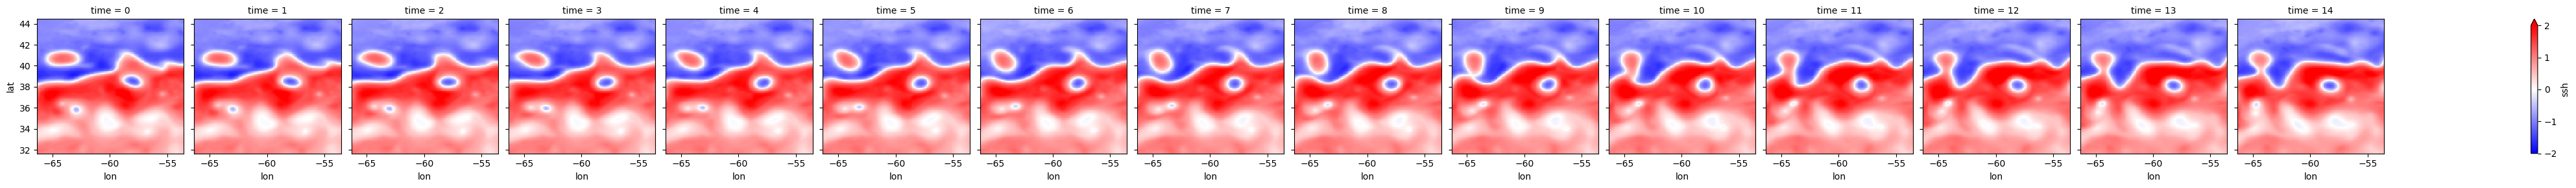

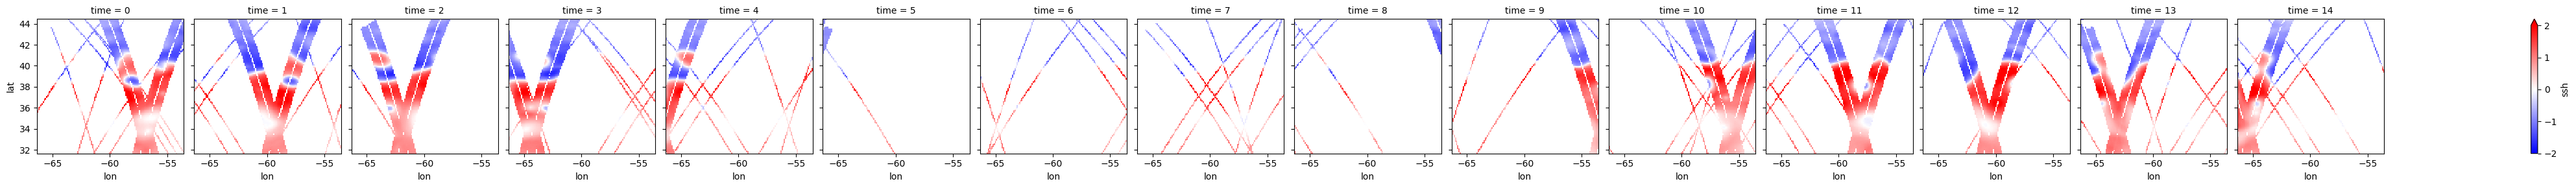

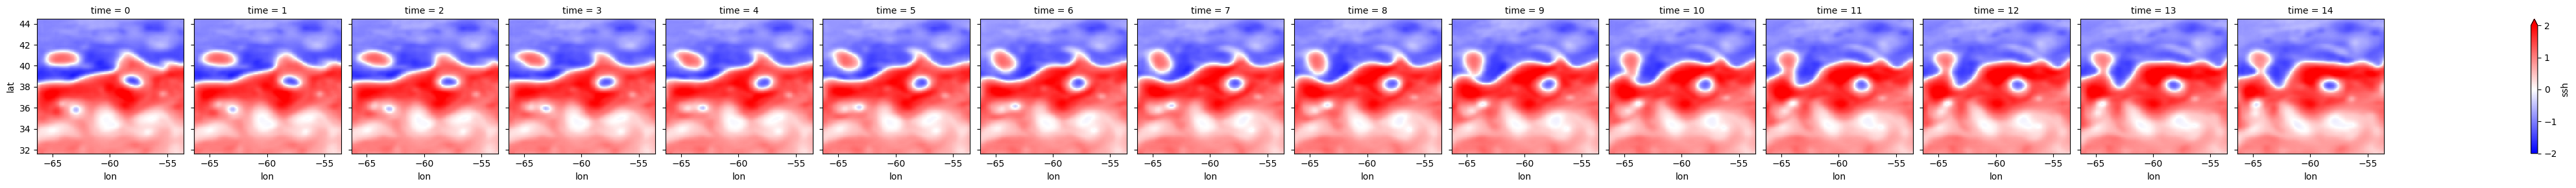

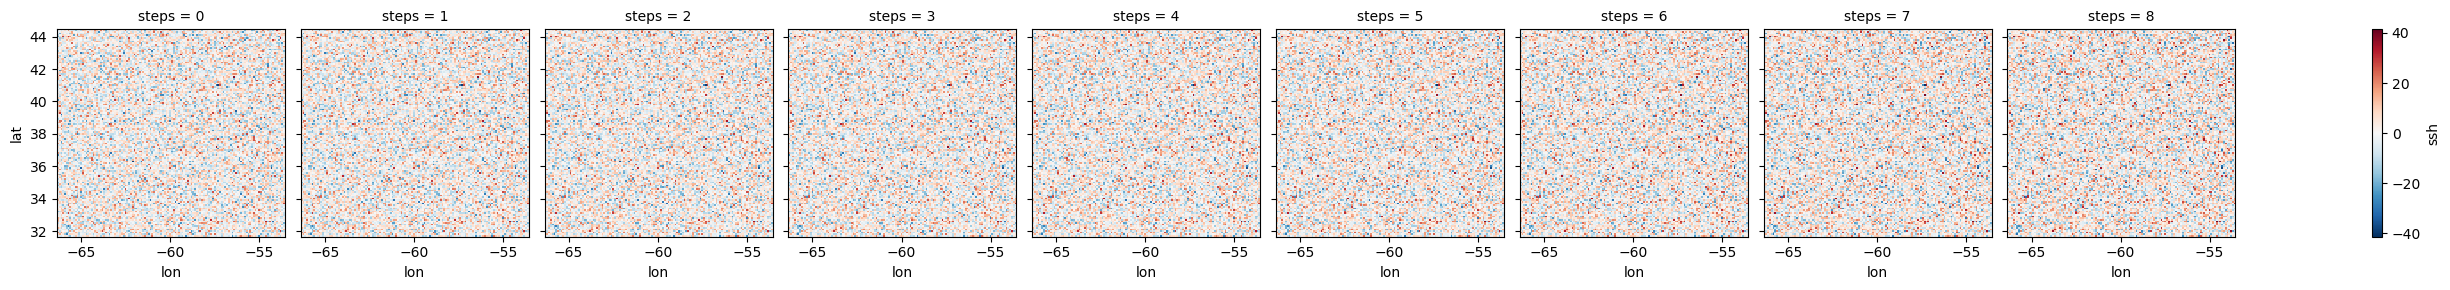

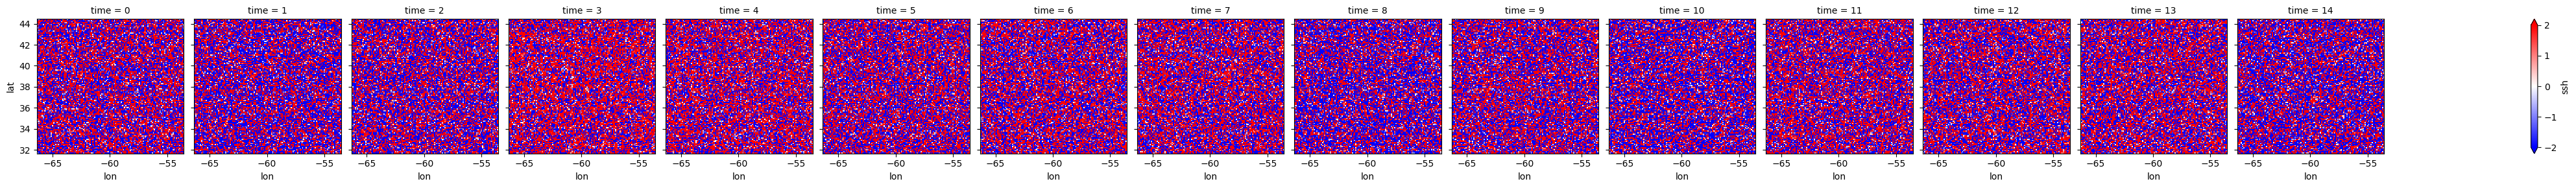

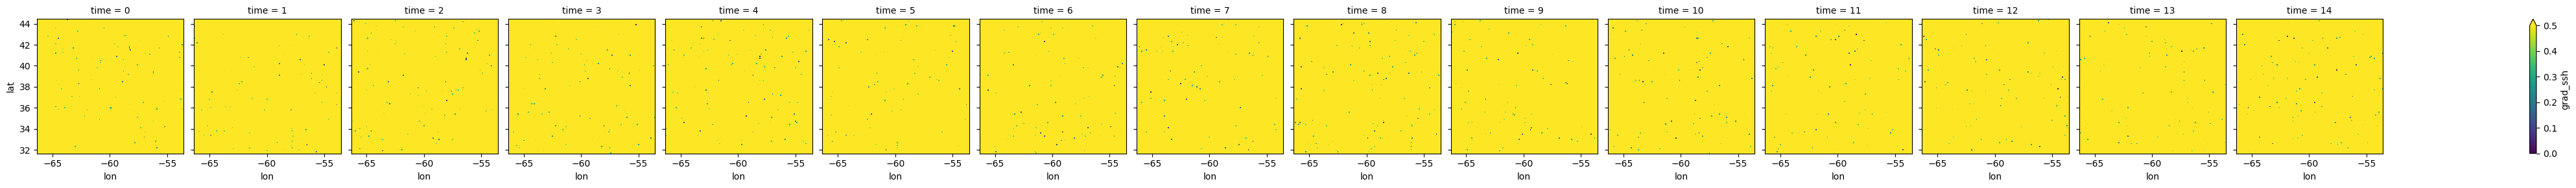

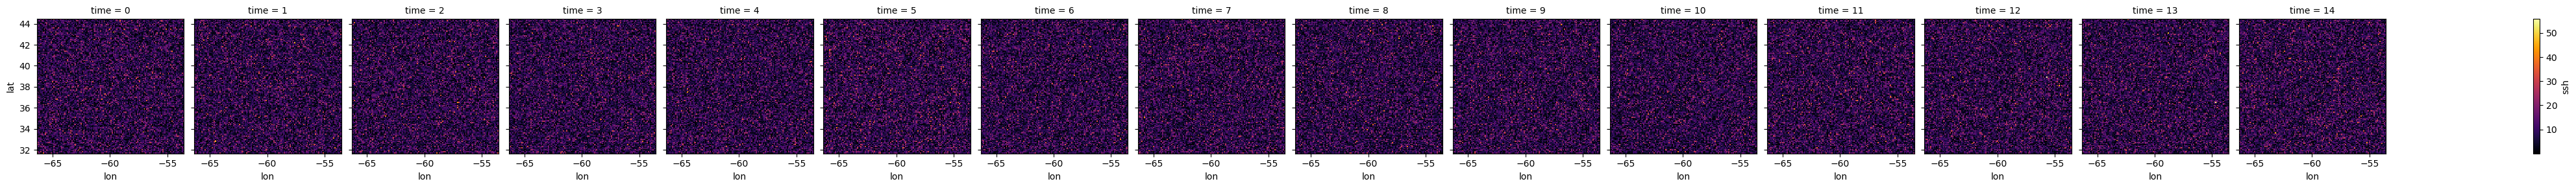

In [35]:
# test
from IPython.display import clear_output
ckpt = torch.load('../ckpt/ckpt_4dvarNet_diff.pth', map_location=device)
solver.load_state_dict(ckpt)

from kornia.filters import sobel

k = 3
test_batch = next(itertools.islice(datamodule.test_dataloader(), k, None))

xr.Dataset(data_vars={'ssh':(('time','lat','lon'),test_batch.tgt[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(15),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),test_batch.input[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(15),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),(solver.prior_cost.forward_ae(test_batch.tgt.to(device)))[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(15),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)

test_batch = test_batch._replace(input=test_batch.input.nan_to_num().to(device))
test_batch = test_batch._replace(tgt=test_batch.tgt.nan_to_num().to(device))

out, all_steps = solver(test_batch)
all_steps = torch.stack(all_steps,dim=1)
xr.Dataset(data_vars={'ssh':(('steps','lat','lon'),all_steps[0,:,7,:,:].detach().cpu())},
           coords={'steps':np.arange(9),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='steps',col_wrap=9)#, vmin=-2, vmax=2)


out = []
for i in range(2):
    print(i)
    out.append(solver(test_batch)[0].detach())

xr.Dataset(data_vars={'ssh':(('time','lat','lon'),out[0][0,:,:,:].detach().cpu())},
           coords={'time':np.arange(15),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)

xr.Dataset(data_vars={'grad_ssh':(('time','lat','lon'),sobel(out[0])[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(15),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).grad_ssh.plot(col='time',vmin=0,vmax=0.5)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),torch.std(torch.stack(out,dim=0),dim=0)[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(15),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',cmap=plt.cm.inferno)